In [1803]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np
from sklearn import model_selection
from sklearn import tree
import math
import graphviz 

**1. В коде из методички реализуйте один или несколько критериев останова (количество листьев, глубина дерева и т.д.).**

* Вынесен параметр **min_leaf** из тела функции и сделан как регулируемый параметр.
* Создан критерий останова **max_depth**.

**2. Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.**

* Дописан метод **shennon** для расчета критерия Шеннона (Энтропии). 
* На качество классификации оба критерия воздействуют одинаково. Значения **accuracy** равны, как на малой выборке, так и на большой.

In [1804]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification( 
                                                      n_samples=100, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant = 0, 
                                                      n_clusters_per_class = 1, 
                                                      random_state = 5
                                                                         )

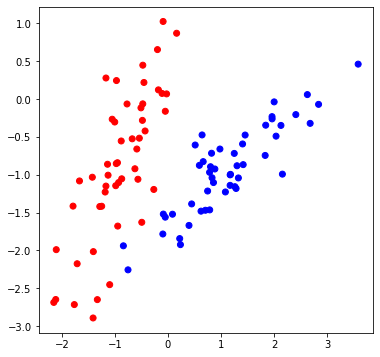

In [1805]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [1806]:
# Класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [1807]:
# Класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        self.prediction_reg = self.predict_reg()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        
    
    def predict_reg(self):
        # подсчет среднего значения по выборке
        prediction = np.mean(labels)
        return prediction 

In [1808]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [1809]:
# Расчет критерия Шеннона (Энтропии)

def shennon(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entropy = 0
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p * math.log(p, 2)
        
    return entropy

In [1810]:
# Расчет качества

def quality(left_labels, right_labels, current_gini, current_shennon, criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    if criterion == 'gini':
        return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)
    elif criterion == 'shennon':
        return current_shennon - p * shennon(left_labels) - (1 - p) * shennon(right_labels)

In [1811]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [1812]:
# Нахождение наилучшего разбиения
# Аналог метода fit()

def find_best_split(data, labels, min_leaf, criterion):
    
    #  обозначим минимальное количество объектов в узле
    # min_leaf = 5

    current_gini = gini(labels)
    current_shennon = shennon(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
         
            current_quality = quality(true_labels, false_labels, current_gini, current_shennon, criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [1813]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf=5, depth=0, max_depth=None, criterion='gini'):

    quality, t, index = find_best_split(data, labels, min_leaf, criterion)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or depth >= max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf, depth + 1, max_depth, criterion)
    false_branch = build_tree(false_data, false_labels, min_leaf, depth + 1, max_depth, criterion)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [1814]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [1815]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [1816]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [1817]:
# Построим дерево по обучающей выборке
my_tree_gini = build_tree(train_data, train_labels, min_leaf=5, max_depth=5, criterion='gini')
my_tree_shennon = build_tree(train_data, train_labels, min_leaf=5, max_depth=5, criterion='shennon')

In [1818]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    

In [1819]:
print(f'GINI TREE\n')
print_tree(my_tree_gini)

GINI TREE

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [1820]:
print(f'SHENNON TREE\n')
print_tree(my_tree_shennon)

SHENNON TREE

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


[Text(223.20000000000002, 190.26, 'X[0] <= 0.192\ngini = 0.5\nsamples = 70\nvalue = [35, 35]'),
 Text(167.4, 135.9, 'X[1] <= -1.469\ngini = 0.219\nsamples = 40\nvalue = [35, 5]'),
 Text(111.60000000000001, 81.53999999999999, 'X[0] <= -0.895\ngini = 0.486\nsamples = 12\nvalue = [7, 5]'),
 Text(55.800000000000004, 27.180000000000007, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(167.4, 27.180000000000007, 'gini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(223.20000000000002, 81.53999999999999, 'gini = 0.0\nsamples = 28\nvalue = [28, 0]'),
 Text(279.0, 135.9, 'gini = 0.0\nsamples = 30\nvalue = [0, 30]')]

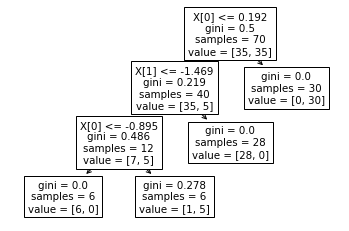

In [1821]:
X, y = train_data, train_labels
clf_gini = tree.DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=5)
clf_gini = clf_gini.fit(X, y)
# min_samples_leaf - количество узлов
# max_leaf_nodes - количество листьев

tree.plot_tree(clf_gini)

[Text(223.20000000000002, 190.26, 'X[0] <= 0.192\nentropy = 1.0\nsamples = 70\nvalue = [35, 35]'),
 Text(167.4, 135.9, 'X[1] <= -1.469\nentropy = 0.544\nsamples = 40\nvalue = [35, 5]'),
 Text(111.60000000000001, 81.53999999999999, 'X[0] <= -0.895\nentropy = 0.98\nsamples = 12\nvalue = [7, 5]'),
 Text(55.800000000000004, 27.180000000000007, 'entropy = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(167.4, 27.180000000000007, 'entropy = 0.65\nsamples = 6\nvalue = [1, 5]'),
 Text(223.20000000000002, 81.53999999999999, 'entropy = 0.0\nsamples = 28\nvalue = [28, 0]'),
 Text(279.0, 135.9, 'entropy = 0.0\nsamples = 30\nvalue = [0, 30]')]

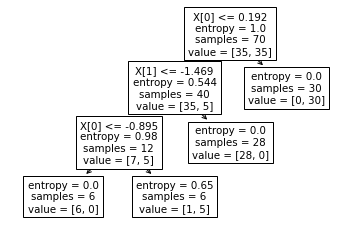

In [1822]:
X, y = train_data, train_labels
clf_entropy = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5)
clf_entropy = clf_entropy.fit(X, y)

tree.plot_tree(clf_entropy)

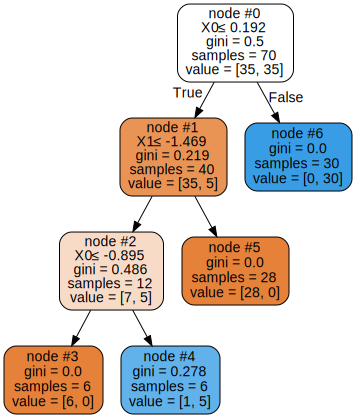

In [1823]:
dot_data = tree.export_graphviz(clf_gini, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Gini") 
dot_data = tree.export_graphviz(clf_gini, out_file=None, 
                     filled=True, rounded=True,  
                     special_characters=True, node_ids=True)  
graph = graphviz.Source(dot_data)  
graph 

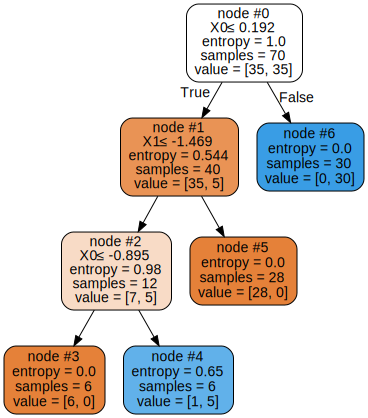

In [1824]:
dot_data = tree.export_graphviz(clf_entropy, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Entropy") 
dot_data = tree.export_graphviz(clf_entropy, out_file=None, 
                     filled=True, rounded=True,  
                     special_characters=True, node_ids=True)  
graph = graphviz.Source(dot_data)  
graph 

In [1825]:
# Получим ответы для обучающей выборки 
train_answers_gini = predict(train_data, my_tree_gini)
train_answers_shennon = predict(train_data, my_tree_shennon)

# И получим ответы для тестовой выборки
answers_gini = predict(test_data, my_tree_gini)
answers_shennon = predict(test_data, my_tree_shennon)

In [1826]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [1827]:
# Точность на обучающей выборке
train_accuracy_gini = accuracy_metric(train_labels, train_answers_gini)
train_accuracy_shennon = accuracy_metric(train_labels, train_answers_shennon)
train_accuracy_gini, train_accuracy_shennon  # При выборке в 1000 экземпляров (97.14285714285714, 97.14285714285714)

(98.57142857142858, 98.57142857142858)

In [1828]:
# Точность на тестовой выборке
test_accuracy_gini = accuracy_metric(test_labels, answers_gini)
test_accuracy_shennon = accuracy_metric(test_labels, answers_shennon)
test_accuracy_gini, test_accuracy_shennon  # При выборке в 1000 экземпляров (93.66666666666667, 93.66666666666667)

(100.0, 100.0)

Text(0.5, 1.0, 'Test accuracy SHENNON=100.00')

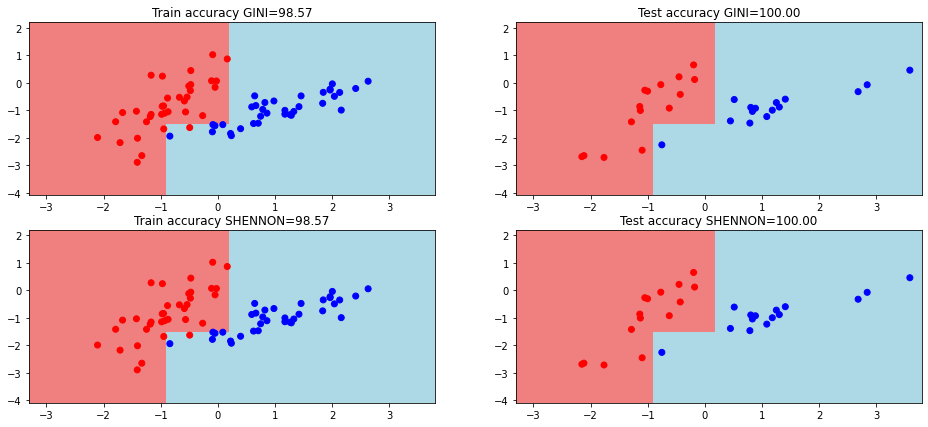

In [1829]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(2,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_gini)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy GINI={train_accuracy_gini:.2f}')

# график тестовой выборки
plt.subplot(2,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy GINI={test_accuracy_gini:.2f}')

# график обучающей выборки
plt.subplot(2,2,3)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_shennon)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy SHENNON={train_accuracy_shennon:.2f}')

# график тестовой выборки
plt.subplot(2,2,4)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy SHENNON={test_accuracy_shennon:.2f}')

**3. (\*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений.**

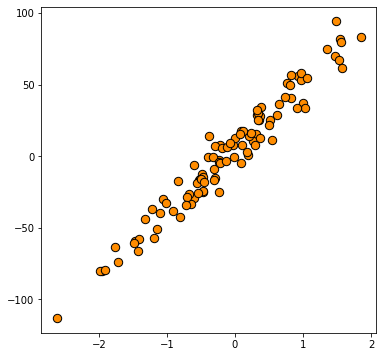

In [1830]:
# 3

regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, bias=5, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);

In [1831]:
# Расчет качества

def quality_reg(left_labels, right_labels, current_var):

    # доля выбоки, ушедшая в левое поддерево
    p = np.mean(left_labels.shape[0] + right_labels.shape[0])
    return current_var - p * np.var(left_labels) - (1 - p) * np.var(right_labels)

In [1832]:
# Нахождение наилучшего разбиения
# Аналог метода fit()

def find_best_split_reg(data, labels, min_leaf):
    
    # расчет дисперсии значений
    current_var = var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
         
            current_quality = quality_reg(true_labels, false_labels, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [1833]:
# Построение дерева с помощью рекурсивной функции

def build_tree_reg(data, labels, min_leaf=5, depth=0, max_depth=None):

    quality, t, index = find_best_split_reg(data, labels, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or depth >= max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_reg(true_data, true_labels, min_leaf, depth + 1, max_depth)
    false_branch = build_tree_reg(false_data, false_labels, min_leaf, depth + 1, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [1834]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction_reg
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [1835]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [1836]:
train_data_reg, test_data_reg, train_labels_reg, test_labels_reg = model_selection.train_test_split(regression_data, 
                                                                                    regression_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [1837]:
# Построим дерево по обучающей выборке
my_tree_reg = build_tree(train_data_reg, train_labels_reg, min_leaf=5, max_depth=5)

In [1838]:
print(f'REGRESSION TREE\n')
print_tree(my_tree_reg)

REGRESSION TREE

Индекс 0
Порог 0.9755451271223592
--> True:
  Индекс 0
  Порог -0.5443827245251827
  --> True:
    Индекс 0
    Порог -1.4785219903674274
    --> True:
      Прогноз: -79.1885154282154
    --> False:
      Индекс 0
      Порог -0.9080240755212109
      --> True:
        Прогноз: -32.499144401574085
      --> False:
        Прогноз: -26.50037869840776
  --> False:
    Индекс 0
    Порог 0.6476885381006925
    --> True:
      Индекс 0
      Порог -0.3092123758512146
      --> True:
        Прогноз: -16.57832635950281
      --> False:
        Индекс 0
        Порог -0.07201012158033385
        --> True:
          Прогноз: 9.339228940229187
        --> False:
          Прогноз: 27.78482382219068
    --> False:
      Прогноз: 33.579735362792675
--> False:
  Индекс 0
  Порог 1.477894044741516
  --> True:
    Прогноз: 94.03314516693368
  --> False:
    Прогноз: 83.0850789964932


In [1839]:
X, y = regression_data, regression_labels
clf_reg = tree.DecisionTreeRegressor(max_depth=5, min_samples_leaf=5)
clf_reg = clf_reg.fit(X, y)

# tree.plot_tree(clf_reg)

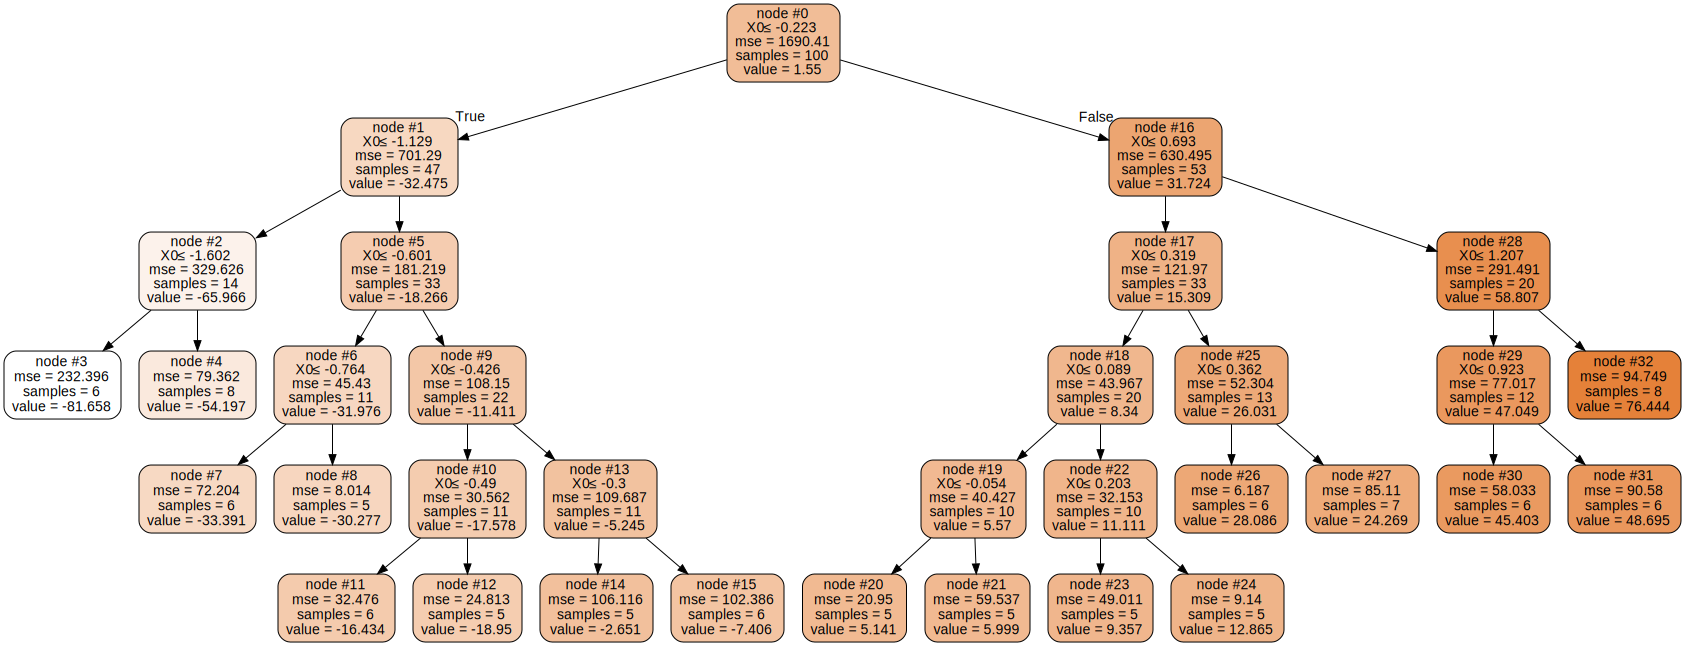

In [1840]:
dot_data = tree.export_graphviz(clf_reg, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Regression") 
dot_data = tree.export_graphviz(clf_reg, out_file=None, 
                     filled=True, rounded=True,  
                     special_characters=True, node_ids=True)  
graph = graphviz.Source(dot_data)  
graph 

In [1841]:
# Получим ответы для обучающей выборки 
train_answers_reg = predict(train_data_reg, my_tree_reg)

# И получим ответы для тестовой выборки
answers_reg = predict(test_data_reg, my_tree_reg)

In [1842]:
# Точность на обучающей выборке
train_accuracy_reg = accuracy_metric(train_labels_reg, train_answers_reg)
train_accuracy_reg

0.0

In [1843]:
# Точность на тестовой выборке
test_accuracy_reg = accuracy_metric(test_labels_reg, answers_reg)
test_accuracy_reg

0.0

In [1844]:
# import matplotlib.pyplot as plt
# import random

# from matplotlib.colors import ListedColormap
# from sklearn import datasets

# import numpy as np
# from sklearn import model_selection
# from sklearn import tree

# # сгенерируем данные
# classification_data, classification_labels = datasets.make_classification(
#     n_samples=100,
#     n_features=2, n_informative=2,
#     n_classes=2, n_redundant=0,
#     n_clusters_per_class=1,
#     random_state=5
# )


# # Класс узла

# class Node:

#     def __init__(self, index, t, true_branch, false_branch):
#         self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
#         self.t = t  # значение порога
#         self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
#         self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


# # Класс терминального узла (листа)

# class Leaf:

#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels
#         self.prediction = self.predict()
#         self.leaves_count = 0

#     def predict(self):
#         # подсчет количества объектов разных классов
#         classes = {}  # сформируем словарь "класс: количество объектов"
#         for label in self.labels:
#             if label not in classes:
#                 classes[label] = 0
#             classes[label] += 1
#         #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
#         prediction = max(classes, key=classes.get)
#         return prediction

#     # Класс дерева


# class MyDecisionTree:

#     def __init__(self, min_leaf=2, max_depth=None, max_leaves=None):
#         self.min_leaf = min_leaf
#         self.max_depth = max_depth
#         self.max_leaves = max_leaves
#         self.leaves_count = 0

#     # Расчет критерия Джини
#     def gini(self, labels):
#         #  подсчет количества объектов разных классов
#         classes = {}
#         for label in labels:
#             if label not in classes:
#                 classes[label] = 0
#             classes[label] += 1

#         #  расчет критерия
#         impurity = 1  # коэффициент неопределенности Джини
#         for label in classes:
#             p = classes[label] / len(labels)
#             impurity -= p ** 2

#         return impurity

#     # Расчет качества
#     def quality(self, left_labels, right_labels, current_gini):

#         # доля выбоки, ушедшая в левое поддерево
#         p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

#         return current_gini - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)

#     
#     # Разбиение датасета в узле
#     def split(data, labels, index, t):

#         left = np.where(data[:, index] <= t)
#         right = np.where(data[:, index] > t)

#         true_data = data[left]
#         false_data = data[right]
#         true_labels = labels[left]
#         false_labels = labels[right]

#         return true_data, false_data, true_labels, false_labels

#     # Нахождение наилучшего разбиения
#     def find_best_split(self, data, labels, min_leaf):

#         # обозначим минимальное количество объектов в узле
#         # min_leaf = 5   # Вынесем переменную, как задаваемый параметр

#         current_gini = self.gini(labels)

#         best_quality = 0
#         best_t = None
#         best_index = None

#         n_features = data.shape[1]

#         for index in range(n_features):
#             # будем проверять только уникальные значения признака, исключая повторения
#             t_values = np.unique([row[index] for row in data])

#             for t in t_values:
#                 true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
#                 #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#                 if len(true_data) < min_leaf or len(false_data) < min_leaf:
#                     continue

#                 current_quality = self.quality(true_labels, false_labels, current_gini)

#                 #  выбираем порог, на котором получается максимальный прирост качества
#                 if current_quality > best_quality:
#                     best_quality, best_t, best_index = current_quality, t, index

#         return best_quality, best_t, best_index

#         # Построение дерева с помощью рекурсивной функции
#         # Аналог метода fit()

#     def build_tree(self, data, labels, min_depth=0):

#         quality, t, index = self.find_best_split(data, labels, self.min_leaf)

#         #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
#         if (quality == 0) or (min_depth >= self.max_depth) or (self.leaves_count >= self.max_leaves):
#             self.leaves_count += 1
#             return Leaf(data, labels)

#         true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

#         # Рекурсивно строим два поддерева
#         true_branch = self.build_tree(true_data, true_labels, min_depth + 1)
#         false_branch = self.build_tree(false_data, false_labels, min_depth + 1)

#         # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
#         print(f'level {min_depth}, leaves {self.leaves_count}')
#         print(index, t)
#         return Node(index, t, true_branch, false_branch)

#     def classify_object(self, obj, node):

#         # Останавливаем рекурсию, если достигли листа
#         if isinstance(node, Leaf):
#             answer = node.prediction
#             print(answer)
#             return answer

#         if obj[node.index] <= node.t:
#             return self.classify_object(obj, node.true_branch)
#         else:
#             return self.classify_object(obj, node.false_branch)

#     def predict(self, data, tree_):

#         classes = []
#         for obj in data:
#             prediction = self.classify_object(obj, tree_)
#             classes.append(prediction)
#         return classes


# # Разобьем выборку на обучающую и тестовую
# train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
#                                                                                     classification_labels,
#                                                                                     test_size=0.3,
#                                                                                     random_state=1)

# my_trees = MyDecisionTree(min_leaf=5, max_depth=2, max_leaves=1)
# my_trees.build_tree(train_data, train_labels)
